In [24]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]

In [25]:
project_directory = os.path.dirname(os.getcwd())
raw_matches = os.path.join("data", "raw", "matches.csv")

df = pd.read_csv(os.path.join(project_directory, raw_matches),
                 index_col=0).reset_index(drop=True)
df.head()


,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Opponent Code,Team,Team Code
0,Sun,10/10/1920,H,Columbus Panhandles,37-0,W,NaN,"Akron, OH",League Park,1500.0,NaN,col,Akron Pros,akr
1,Sun,10/24/1920,H,Cleveland Tigers,7-0,W,NaN,"Akron, OH",League Park,5000.0,NaN,cle,Akron Pros,akr
2,Sun,10/31/1920,A,Canton Bulldogs,10-0,W,NaN,"Canton, OH",Lakeside Athletic Park,6000.0,NaN,can,Akron Pros,akr
3,Sun,11/7/1920,A,Rock Island Independents,NaN,-,NaN,"Rock Island, IL",Douglas Park,NaN,Canceled,ri,Akron Pros,akr
4,Sun,11/7/1920,H,Detroit Heralds,NaN,-,NaN,"Akron, OH",League Park,NaN,Canceled,det,Akron Pros,akr


In [26]:
# Take only home matches, can reconstruct away matches.
# Helps filter outliers.

# df = df.loc[df['Home/Away'] == 'H']
# df.drop(columns='Home/Away', inplace=True)

df.dropna(axis=0, subset=['Score'], inplace=True)

# Turns out there's a typo, fix by knowing the right answer
df.loc[29783, 'Score'] = '9-24'

df['Date'] = pd.to_datetime(df.Date)
df[['Team Score', 'Opponent Score']] = df.Score.str.split('-', expand=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31852 entries, 0 to 32327
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             31852 non-null  object        
 1   Date            31852 non-null  datetime64[ns]
 2   Home/Away       31852 non-null  object        
 3   Opponent        31852 non-null  object        
 4   Score           31852 non-null  object        
 5   W/L/T           31852 non-null  object        
 6   Overtime        1090 non-null   object        
 7   Location        31852 non-null  object        
 8   Venue           31851 non-null  object        
 9   Attendance      31534 non-null  float64       
 10  Notes           1307 non-null   object        
 11  Opponent Code   31852 non-null  object        
 12  Team            31852 non-null  object        
 13  Team Code       31852 non-null  object        
 14  Team Score      31852 non-null  object        
 15  Op

In [27]:
categorical_cols = [
    'Day',
    'W/L/T',
    'Team Code',
    'Opponent Code'
]
numeric_cols = [
    'Team Score',
    'Opponent Score'
]

df[categorical_cols] = df[categorical_cols].astype(
    'category')

for col in categorical_cols:
    print(col + ':', df[col].cat.categories,'| len:' , len(df[col].cat.categories))

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

Day: Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object') | len: 7
W/L/T: Index(['2', 'L', 'T', 'W'], dtype='object') | len: 4
Team Code: Index(['akr', 'ari', 'atl', 'bal', 'bkn', 'bos', 'buf', 'c-p', 'can', 'car',
       ...
       'sd', 'sea', 'sf', 'si', 'stl', 'tb', 'ten', 'tol', 'ton', 'was'],
      dtype='object', length=103) | len: 103
Opponent Code: Index(['akr', 'ari', 'atl', 'bal', 'bkn', 'bos', 'buf', 'c-p', 'can', 'car',
       'chib', 'chic', 'chit', 'cin', 'cle', 'col', 'dal', 'day', 'dec', 'den',
       'det', 'dul', 'eva', 'fra', 'gb', 'ham', 'har', 'hou', 'ind', 'jac',
       'kc', 'ken', 'la', 'lac', 'lari', 'larm', 'lou', 'lv', 'mia', 'mil',
       'min', 'mun', 'ne', 'new', 'no', 'ny', 'nyb', 'nyg', 'nyj', 'nyy',
       'oak', 'oor', 'ora', 'p-p', 'phi', 'phx', 'pit', 'por', 'pot', 'pro',
       'rac', 'ri', 'roc', 'sd', 'sea', 'sf', 'si', 'stl', 'tb', 'ten', 'tol',
       'ton', 'was'],
      dtype='object') | len: 73


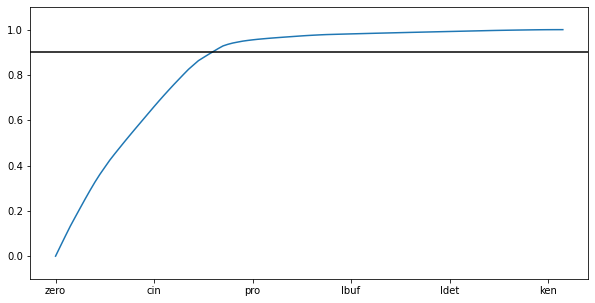

Included labels: 31 from gb ... ari


In [28]:
# Experiment with including only the teams that
# played the most games.
# In this case, inclusion rate is the cutoff
# for the cumulative sum of the teams with
# the most played games.
inclusion_rate = 0.9

code_frequencies = df['Team Code'].value_counts()
cumsum_freq = code_frequencies.cumsum()
freq_max = cumsum_freq.max()
cumsum_freq = cumsum_freq / freq_max

included_labels = cumsum_freq.index[cumsum_freq <= inclusion_rate]
included_x = cumsum_freq.index.get_loc(included_labels[-1])

zero_based = pd.Series([0], index=['zero']).append(cumsum_freq)

zero_based.plot()
plt.axhline(inclusion_rate, color='k')
plt.ylim(-0.1, 1.1)
plt.show()
print(f'Included labels: {len(included_labels)} from {included_labels[0]} ... {included_labels[-1]}')

df_reduced = df[df['Team Code'].isin(included_labels) & df['Opponent Code'].isin(included_labels)].reset_index(drop=True)

In [29]:
def applicable_remove_unused(series:pd.Series):
  return series.cat.remove_unused_categories()
df_reduced[categorical_cols] = df_reduced[categorical_cols].apply(applicable_remove_unused)
df_reduced.head()

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Opponent Code,Team,Team Code,Team Score,Opponent Score
0,Sun,1920-11-28,H,Cleveland Tigers,7-0,W,NaN,"Buffalo, NY",Buffalo Baseball Park,5000.0,NaN,cle,Buffalo All-Americans,buf,7,0
1,Sun,1920-10-31,H,Detroit Heralds,21-0,W,NaN,"Chicago, IL",Cubs Park,3000.0,NaN,det,Chicago Cardinals,chic,21,0
2,Sun,1920-10-31,A,Chicago Cardinals,0-21,L,NaN,"Chicago, IL",Cubs Park,3000.0,NaN,chic,Detroit Heralds,det,0,21
3,Sun,1920-11-28,A,Buffalo All-Americans,0-7,L,NaN,"Buffalo, NY",Buffalo Baseball Park,5000.0,NaN,buf,Cleveland Tigers,cle,0,7
4,Sun,1921-10-30,H,Detroit Tigers,21-0,W,NaN,"Buffalo, NY",Canisius Villa,7000.0,NaN,det,Buffalo All-Americans,buf,21,0


In [30]:
df_reduced[numeric_cols].describe()


,Team Score,Opponent Score
count,26128.000000,26128.000000
mean,20.646203,20.653437
std,10.788249,10.980790
min,0.000000,0.000000
25%,13.000000,13.000000
50%,20.000000,20.000000
75%,27.000000,27.000000
max,73.000000,347.000000


In [31]:
df_reduced[categorical_cols].describe()

,Day,W/L/T,Team Code,Opponent Code
count,26128,26128,26128,26128
unique,7,3,31,31
top,Sun,W,gb,gb
freq,22906,12903,1292,1290


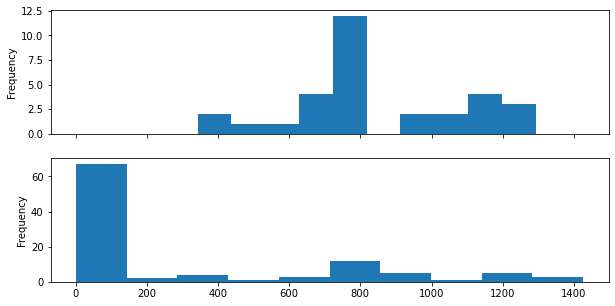

In [32]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
df_reduced['Team Code'].value_counts().plot.hist(ax=ax1)
df['Team Code'].value_counts().plot.hist(ax=ax2)
plt.show()

In [33]:
sort_by_date = df_reduced.sort_values(by=['Date', 'Team Code'])
sort_by_date.head()

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,Notes,Opponent Code,Team,Team Code,Team Score,Opponent Score
1,Sun,1920-10-31,H,Detroit Heralds,21-0,W,NaN,"Chicago, IL",Cubs Park,3000.0,NaN,det,Chicago Cardinals,chic,21,0
2,Sun,1920-10-31,A,Chicago Cardinals,0-21,L,NaN,"Chicago, IL",Cubs Park,3000.0,NaN,chic,Detroit Heralds,det,0,21
0,Sun,1920-11-28,H,Cleveland Tigers,7-0,W,NaN,"Buffalo, NY",Buffalo Baseball Park,5000.0,NaN,cle,Buffalo All-Americans,buf,7,0
3,Sun,1920-11-28,A,Buffalo All-Americans,0-7,L,NaN,"Buffalo, NY",Buffalo Baseball Park,5000.0,NaN,buf,Cleveland Tigers,cle,0,7
8,Sun,1921-10-02,H,Minneapolis Marines,20-0,W,NaN,"Chicago, IL",Normal Park,4000.0,NaN,min,Chicago Cardinals,chic,20,0


<AxesSubplot:xlabel='W/L/T', ylabel='Team Score'>

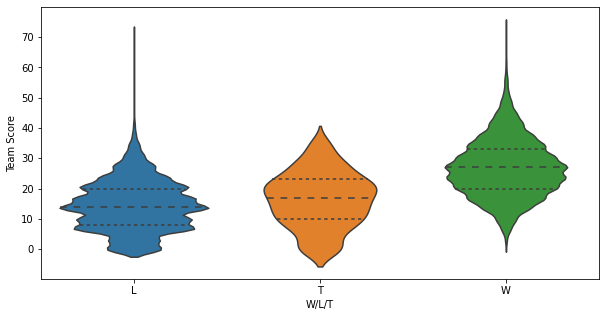

In [34]:
sns.violinplot(x='W/L/T', y='Team Score', data=sort_by_date, inner='quartile')


In [35]:
sort_by_date['Score Sum'] = sort_by_date['Team Score'] + sort_by_date['Opponent Score']

<AxesSubplot:xlabel='W/L/T', ylabel='Score Sum'>

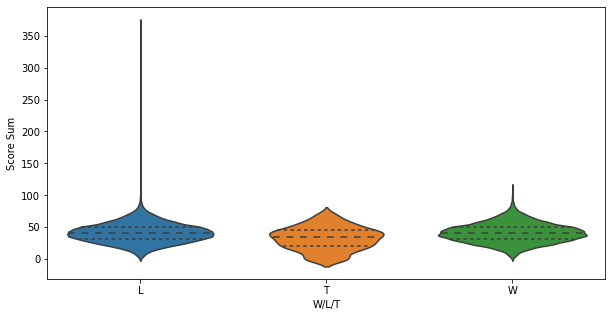

In [36]:
sns.violinplot(x='W/L/T', y='Score Sum', data=sort_by_date, inner='quartile')


In [37]:
# Exclude outliers
numerical = sort_by_date[numeric_cols]
numerical = numerical[(np.abs(stats.zscore(numerical))<3).all(axis=1)]
sort_by_date[numeric_cols] = numerical
sort_by_date['Score Sum'] = sort_by_date['Team Score'] + sort_by_date['Opponent Score']
sort_by_date['Score Diff'] = sort_by_date['Team Score'] - sort_by_date['Opponent Score']


<AxesSubplot:xlabel='W/L/T', ylabel='Team Score'>

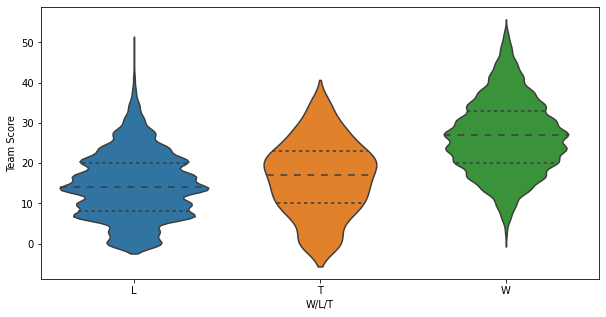

In [38]:
sns.violinplot(x='W/L/T', y='Team Score', data=sort_by_date, inner='quartile')


<AxesSubplot:xlabel='W/L/T', ylabel='Opponent Score'>

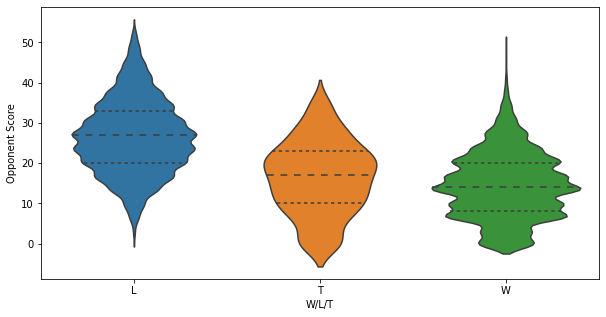

In [39]:
sns.violinplot(x='W/L/T', y='Opponent Score', data=sort_by_date, inner='quartile')

<AxesSubplot:xlabel='W/L/T', ylabel='Score Sum'>

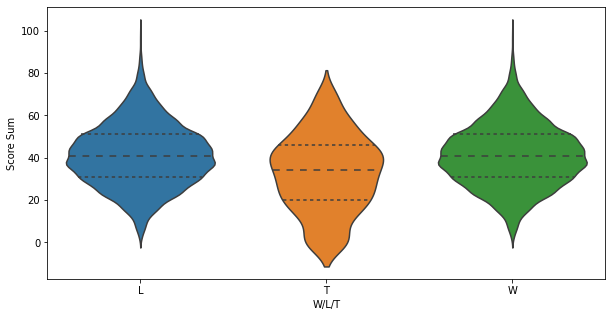

In [40]:
sns.violinplot(x='W/L/T', y='Score Sum', data=sort_by_date, inner='quartile')


<AxesSubplot:xlabel='W/L/T', ylabel='Score Diff'>

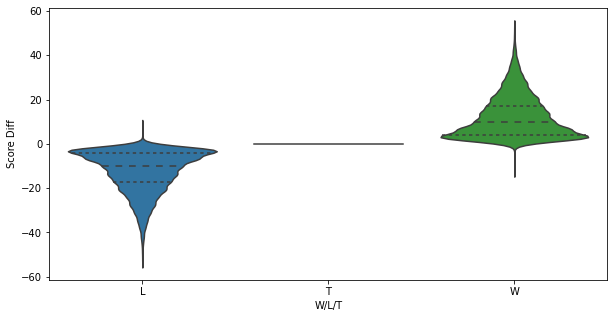

In [41]:
sns.violinplot(x='W/L/T',y='Score Diff',data=sort_by_date, inner='quartile')

In [42]:
sort_by_date['sign'] = sort_by_date['W/L/T'].map({'W':1,'L':-1,'T':0}).astype(int)
sort_by_date = sort_by_date.loc[~((sort_by_date['sign'] * sort_by_date['Score Diff']) < 0)]

<AxesSubplot:xlabel='W/L/T', ylabel='Score Diff'>

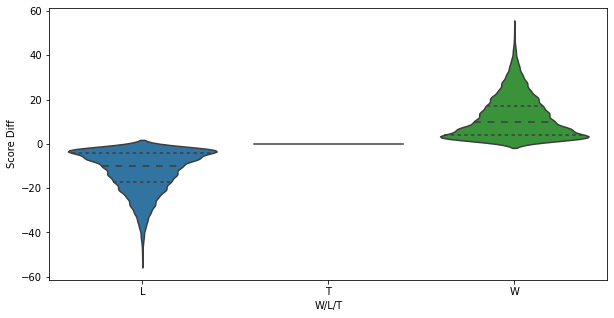

In [43]:
sns.violinplot(x='W/L/T',y='Score Diff',data=sort_by_date, inner='quartile')


In [44]:
cleaned_matches = os.path.join('data','derived','cleaned_matches.csv')
sort_by_date.to_csv(os.path.join(project_directory, cleaned_matches))

Did every team play against other teams? True


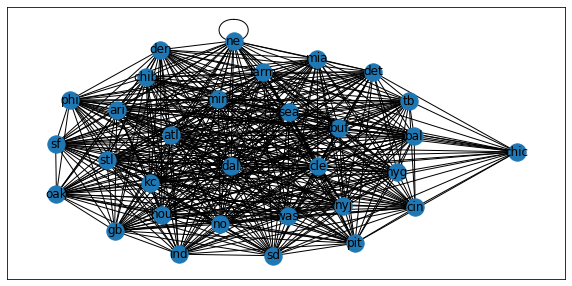

In [45]:
graph = sort_by_date.groupby(['Team Code', 'Opponent Code']).size().reset_index().rename(columns={0:'count'})
graph = graph.loc[graph['count'] > 0]

graph['inv_count'] = graph['count'].max() - graph['count']

g = nx.from_pandas_edgelist(graph, source='Team Code', target='Opponent Code', edge_attr='inv_count')
print('Did every team play against other teams?', nx.is_connected(g))
nx.draw_networkx(g)

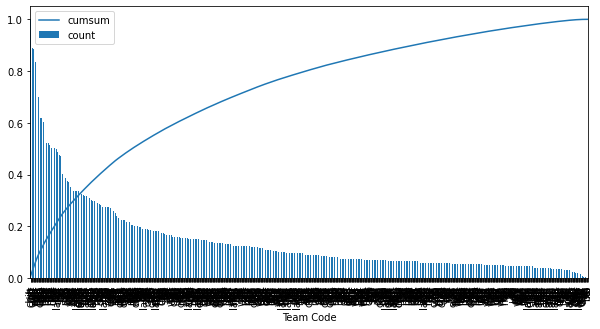

In [46]:
graph.sort_values(by='count',inplace=True, ascending=False)
graph['cumsum'] = graph['count'].cumsum()
graph['cumsum'] /= graph['cumsum'].max()
graph['count'] = graph['count'] / graph['count'].max()

fig, ax = plt.subplots(1, sharex=True)
graph.plot(x='Team Code', y='cumsum', ax=ax)
graph.plot.bar(x='Team Code', y='count', ax=ax)
plt.show()